In [3]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))
import spatial_metrics.helper_functions as hf
import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.detect_peaks as dp
import spatial_metrics.spatial_metrics_spikes_base as pl_spk
import spatial_metrics.spatial_prediction_spikes_base as sp_spk


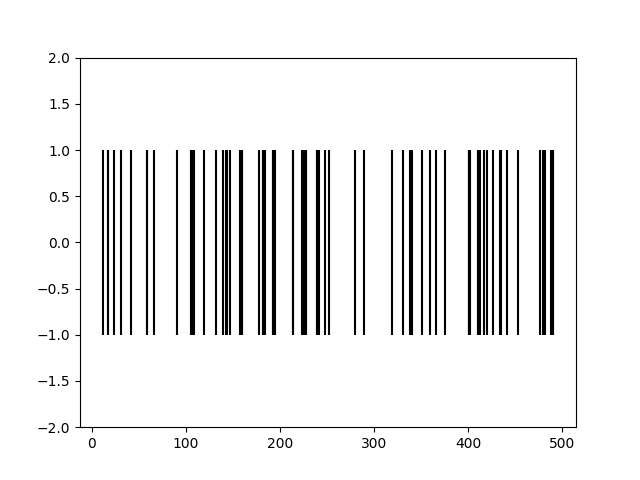

In [6]:
num_of_fields = 1
# Define field parameters
field1_center = (20, 35)
field1_size = 4


sampling_rate = 30. # points/frames per second
duration = 500 # in seconds
rate = 2 # how much your neuron should spike
environment_edges = [[0,30],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]

x_coordinates,y_coordinates,speed,time_vector = cs_model.generate_random_walk(input_srate = sampling_rate,input_total_Time = duration,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = time_vector.shape[0]

spike_times = cs_model.generate_poisson_spikes(rate, duration)
spike_times_idx = (spike_times*sampling_rate).astype(int)

modulated_spike_times_idx = []
for counter in range(num_of_fields):
    field_center = eval('field' + str(counter+1) + '_center')
    field_size = eval('field' + str(counter+1) + '_size')
    modulated_spike_times_idx_aux = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,spike_times_idx,x_center = field_center[0],y_center = field_center[1], s = field_size)

    modulated_spike_times_idx.append(modulated_spike_times_idx_aux)
modulated_spike_times_idx = np.unique(np.concatenate(modulated_spike_times_idx))


plt.figure()
plt.eventplot(time_vector[modulated_spike_times_idx],color='black',lineoffsets=0,linelengths=2)
plt.ylim([-2,2])
plt.show()


In [13]:

def get_spikes_surrogate(time_stamps, time_vector, shift_time_limit):
    """
    Generate a surrogate set of spike timestamps by circularly shifting the original timestamps within a time range.

    Parameters:
        time_stamps (numpy.ndarray): The original spike timestamps.
        time_vector (numpy.ndarray): The time vector associated with the spike timestamps.
        shift_time_limit (float): The maximum time range for circular shifting.

    Returns:
        time_stamps_shifted (numpy.ndarray): The surrogate spike timestamps after circular shifting.
    """
    # Generate a random shift within the specified time range
    shift_this_much = np.random.uniform(-shift_time_limit, shift_time_limit, size=1)
    # Apply the circular shift to the timestamps
    time_stamps_shifted = time_stamps + shift_this_much

    # Get the lower and upper time limits from the time vector
    lower_time_limit = time_vector[0]
    upper_time_limit = time_vector[-1]

    # Apply circular shifting for timestamps exceeding the time range
    time_stamps_shifted[time_stamps_shifted < lower_time_limit] += (upper_time_limit - lower_time_limit)
    time_stamps_shifted[time_stamps_shifted > upper_time_limit] -= (upper_time_limit - lower_time_limit)

    
    return np.sort(time_stamps_shifted)



[0.90996634]


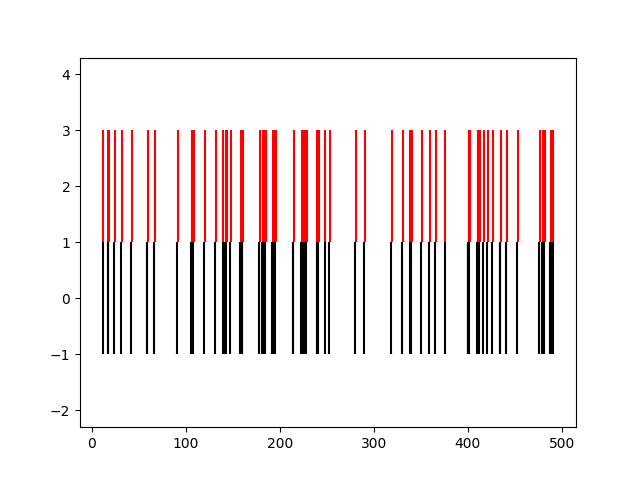

In [14]:
shift_time_limit = 1
time_stamps_shifted = get_spikes_surrogate(time_vector[modulated_spike_times_idx], time_vector, shift_time_limit)

plt.figure()
plt.eventplot(time_vector[modulated_spike_times_idx],color='black',lineoffsets=0,linelengths=2)
plt.eventplot(time_stamps_shifted,color='red',lineoffsets=2,linelengths=2)

# plt.ylim([-2,2])
plt.show()


In [ ]:
def get_spikes_surrogate(self,spike_times_idx,time_vector,sampling_rate,shift_time):
    eps = np.finfo(np.float64).eps
    time_vector_hist = np.append(time_vector,time_vector[-1] + eps)
    spike_timevector = np.histogram(time_vector[spike_times_idx],time_vector_hist)[0]

    I_break = np.random.choice(np.linspace(-shift_time*sampling_rate,sampling_rate*shift_time),1)[0].astype(int)
    input_vector_shifted = np.concatenate([spike_timevector[I_break:], spike_timevector[0:I_break]])

    timestamps_shifted = np.repeat(time_vector, input_vector_shifted)

    spike_times_idx_shifted = self.searchsorted2(time_vector, timestamps_shifted)
    I_keep = np.abs(time_vector[spike_times_idx_shifted]-timestamps_shifted)<0.1
    spike_times_idx_shifted = spike_times_idx_shifted[I_keep]

    return spike_times_idx_shifted
    

In [ ]:
def get_surrogate(self,spike_times_idx,time_vector,sampling_rate,shift_time):
    eps = np.finfo(np.float64).eps
    time_vector_hist = np.append(time_vector,time_vector[-1] + eps)
    spike_timevector = np.histogram(time_vector[spike_times_idx],time_vector_hist)[0]

    I_break = np.random.choice(np.linspace(-shift_time*sampling_rate,sampling_rate*shift_time),1)[0].astype(int)
    input_vector_shifted = np.concatenate([spike_timevector[I_break:], spike_timevector[0:I_break]])

    timestamps_shifted = np.repeat(time_vector, input_vector_shifted)

    spike_times_idx_shifted = self.searchsorted2(time_vector, timestamps_shifted)
    I_keep = np.abs(time_vector[spike_times_idx_shifted]-timestamps_shifted)<0.1
    spike_times_idx_shifted = spike_times_idx_shifted[I_keep]

    return spike_times_idx_shifted

In [ ]:

def cvxpy_foopsi(fluor, g, sn, b=None, c1=None, bas_nonneg=True, solvers=None):
    """Solves the deconvolution problem using the cvxpy package and the ECOS/SCS library.
    Args:
        fluor: ndarray
            fluorescence trace
        g: list of doubles
            parameters of the autoregressive model, cardinality equivalent to p
        sn: double
            estimated noise level
        b: double
            baseline level. If None it is estimated.
        c1: double
            initial value of calcium. If None it is estimated.
        bas_nonneg: boolean
            should the baseline be estimated
        solvers: tuple of two strings
            primary and secondary solvers to be used. Can be choosen between ECOS, SCS, CVXOPT
    Returns:
        c: estimated calcium trace
        b: estimated baseline
        c1: esimtated initial calcium value
        g: esitmated parameters of the autoregressive model
        sn: estimated noise level
        sp: estimated spikes
    Raises:
        ImportError 'cvxpy solver requires installation of cvxpy. Not working in windows at the moment.'
        ValueError 'Problem solved suboptimally or unfeasible'
    """
    # todo: check the result and gen_vector vars
    try:
        import cvxpy as cvx

    except ImportError: # XXX Is the below still true?
        raise ImportError(
            'cvxpy solver requires installation of cvxpy. Not working in windows at the moment.')

    if solvers is None:
        solvers = ['ECOS', 'SCS']

    T = fluor.size

    # construct deconvolution matrix  (sp = G*c)
    G = scipy.sparse.dia_matrix((np.ones((1, T)), [0]), (T, T))

    for i, gi in enumerate(g):
        G = G + \
            scipy.sparse.dia_matrix((-gi * np.ones((1, T)), [-1 - i]), (T, T))

    gr = np.roots(np.concatenate([np.array([1]), -g.flatten()]))
    gd_vec = np.max(gr)**np.arange(T)  # decay vector for initial fluorescence
    gen_vec = G.dot(scipy.sparse.coo_matrix(np.ones((T, 1))))

    c = cvx.Variable(T)  # calcium at each time step
    constraints = []
    cnt = 0
    if b is None:
        flag_b = True
        cnt += 1
        b = cvx.Variable(1)  # baseline value
        if bas_nonneg:
            b_lb = 0
        else:
            b_lb = np.min(fluor)
        constraints.append(b >= b_lb)
    else:
        flag_b = False

    if c1 is None:
        flag_c1 = True
        cnt += 1
        c1 = cvx.Variable(1)  # baseline value
        constraints.append(c1 >= 0)
    else:
        flag_c1 = False

    thrNoise = sn * np.sqrt(fluor.size)

    try:
        # minimize number of spikes
        objective = cvx.Minimize(cvx.norm(G * c, 1))
        constraints.append(G * c >= 0)
        constraints.append(
            cvx.norm(-c + fluor - b - gd_vec * c1, 2) <= thrNoise)  # constraints
        prob = cvx.Problem(objective, constraints)
        result = prob.solve(solver=solvers[0])

        if not (prob.status == 'optimal' or prob.status == 'optimal_inaccurate'):
            raise ValueError('Problem solved suboptimally or unfeasible')

        print(('PROBLEM STATUS:' + prob.status))
        sys.stdout.flush()
    except (ValueError, cvx.SolverError):     # if solvers fail to solve the problem

        lam = old_div(sn, 500)
        constraints = constraints[:-1]
        objective = cvx.Minimize(cvx.norm(-c + fluor - b - gd_vec *
                                          c1, 2) + lam * cvx.norm(G * c, 1))
        prob = cvx.Problem(objective, constraints)

        try:  # in case scs was not installed properly
            try:
                print('TRYING AGAIN ECOS')
                sys.stdout.flush()
                result = prob.solve(solver=solvers[0])
            except:
                print((solvers[0] + ' DID NOT WORK TRYING ' + solvers[1]))
                result = prob.solve(solver=solvers[1])
        except:
            sys.stderr.write(
                '***** SCS solver failed, try installing and compiling SCS for much faster performance. '
                'Otherwise set the solvers in tempora_params to ["ECOS","CVXOPT"]')
            sys.stderr.flush()
            raise

        if not (prob.status == 'optimal' or prob.status == 'optimal_inaccurate'):
            print(('PROBLEM STATUS:' + prob.status))
            sp = fluor
            c = fluor
            b = 0
            c1 = 0
            return c, b, c1, g, sn, sp

    sp = np.squeeze(np.asarray(G * c.value))
    c = np.squeeze(np.asarray(c.value))
    if flag_b:
        b = np.squeeze(b.value)
    if flag_c1:
        c1 = np.squeeze(c1.value)

    return c, b, c1, g, sn, sp


In [ ]:
# import inspect
# lines = inspect.getsource(place_cell.get_position_grid)
# print(lines)

In [2]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))
import spatial_metrics.helper_functions as hf
import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_base as pl
import spatial_metrics.detect_peaks as dp



In [ ]:
# implementing implement other MI definitions: 
# using actiaved vs not activated states
# diff, diff truncated (negative values became zero)
# using spiketimes (in this case, just by feeding with the spike indices for the behavioral series)
# calcium peaks
# calcium rising events
# transients:  during transient the signal is kept intact; outside transients, they are set to zero



In [ ]:
# Place cell papers with calcium imaging

# # Calcium rising events or peaks:
# https://www.jneurosci.org/content/jneuro/early/2022/04/27/JNEUROSCI.1750-21.2022.full.pdf


# Calcium active states:



# Whole calcium signal, diff, diff truncated




In [3]:

srate = 100. # points/frames per second
total_Time = 1000 # in seconds
_lambda = 10 # how much your neuron should spike
environment_edges = [[0,100],[0,100]] # in cm [[x1,x2],[y1,y2]]

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_random_walk(input_srate = srate,input_total_Time = total_Time,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = timevector.shape[0]


timestamps = cs_model.generate_arrivals(_lambda,total_Time)
I_timestamps = (timestamps*srate).astype(int)

# place cell with one field: x_center and y_center is the location of the place field in ehe environment; s is the field variance
modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 35,y_center = 25, s = 2)

# grid cell with several fields
# modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)
# modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 90, s = 5)
# modulated_timestamps4 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 90, s = 5)
# modulated_timestamps5 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3,modulated_timestamps4,modulated_timestamps5]))

# if you want to control for the amount of spikes, set a fixed value for spikes
# num_of_spikes = 50
# modulated_timestamps = np.sort(np.random.choice(modulated_timestamps,num_of_spikes,replace=False))

calcium_imag,timevector = cs_model.generate_calcium_signal(modulated_timestamps,total_points,srate,noise_level = 0.01, b = 5.)
calcium_events = modulated_timestamps.shape[0]
I_peaks = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))




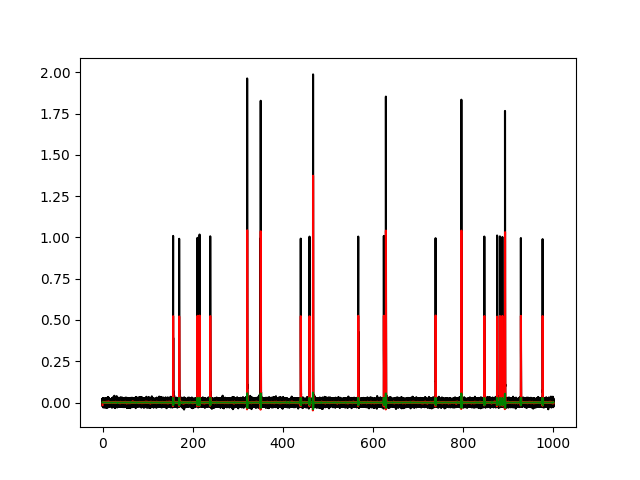

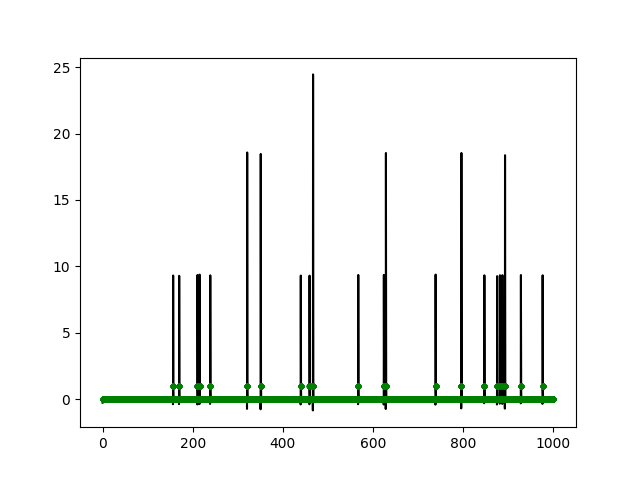

In [10]:

z_threshold = 2
srate = 100

#filtered_signal = hf.eegfilt(calcium_imag,srate,0,2/(srate/2),order=2)
filtered_signal = hf.eegfilt(calcium_imag,srate,0,2,order=2)
norm_signal = filtered_signal/np.std(filtered_signal)

diff_signal = np.hstack([np.diff(filtered_signal),0])
binarized_signal = np.zeros(calcium_imag.shape[0])
binarized_signal[(norm_signal>z_threshold) & (diff_signal>0)] = 1

plt.figure()
plt.plot(timevector,calcium_imag,'k')
plt.plot(timevector,filtered_signal,'r')
plt.plot(timevector,diff_signal,'g')
plt.show()

plt.figure()
plt.plot(timevector,norm_signal,'k')
plt.plot(timevector,diff_signal,'r')
plt.plot(timevector,binarized_signal,'g.',markersize=6)
plt.show()


In [5]:


input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Binarized'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shuffling_shift'] = 100
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 12
input_dict['saving_path'] = None
input_dict['saving'] = False

place_cell = pl.PlaceCellBinarized(**input_dict)

place_cell_output = place_cell.main(binarized_signal,timevector,x_coordinates,y_coordinates)


File not saved!


In [70]:
# Surrogate procedure demonstration - take the signal above, shuffle it and check if it is significant (it shouldn't)

# https://www.sciencedirect.com/science/article/pii/S0370157318301340


input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Shifted'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shuffling_shift'] = 100
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 12
input_dict['saving_path'] = None
input_dict['saving'] = False

place_cell_shuff = pl.PlaceCell(**input_dict)

calcium_imag_shuffled = place_cell_shuff.get_surrogate(calcium_imag,shuffling_shift=200,mean_video_srate = srate)

place_cell_output_shuff = place_cell_shuff.main(calcium_imag_shuffled,timevector,x_coordinates,y_coordinates)


File not saved!


In [81]:
calcium_imag_shuffled = place_cell_shuff.get_surrogate(calcium_imag,shuffling_shift=200,mean_video_srate = srate)


z_threshold = 2
srate = 8.5

filtered_signal = hf.eegfilt(calcium_imag_shuffled,srate,0,2/(srate/2),order=2)
norm_signal = filtered_signal/np.std(filtered_signal)

diff_signal = np.hstack([np.diff(filtered_signal),0])
binarized_signal = np.zeros(calcium_imag_shuffled.shape[0])
binarized_signal[(norm_signal>z_threshold) & (diff_signal>0)] = 1

# I've translated this code to Python. Originally I took it from https://github.com/etterguillaume/CaImDecoding/blob/master/extract_1D_information.m

inclusion_vector = np.ones(binarized_signal.shape[0]).astype(bool)
 # Ignore excluded periods
binarized_signal = binarized_signal[inclusion_vector]
position_binned = position_binned[inclusion_vector]

bin_vector = np.unique(position_binned)

 # Create bin vectors
prob_being_active = np.nansum(binarized_signal)/binarized_signal.shape[0] # Expressed in probability of firing (<1)

 # Compute joint probabilities (of cell being active while being in a state bin)
likelihood = []
occupancy_vector = []

MI = 0
for i in range(bin_vector.shape[0]):
    position_idx = position_binned == bin_vector[i]
    
    if np.sum(position_idx)>0:
        occupancy_vector.append(position_idx.shape[0]/binarized_signal.shape[0])
        
        activity_in_bin_idx = np.where((binarized_signal == 1) & position_idx)[0]
        inactivity_in_bin_idx = np.where((binarized_signal == 0) & position_idx)[0]
        likelihood.append(activity_in_bin_idx.shape[0]/np.sum(position_idx))
        
        joint_prob_active = activity_in_bin_idx.shape[0]/binarized_signal.shape[0]
        joint_prob_inactive = inactivity_in_bin_idx.shape[0]/binarized_signal.shape[0]
        prob_in_bin = np.sum(position_idx)/binarized_signal.shape[0]
        
        if joint_prob_active > 0:
            MI = MI + joint_prob_active*np.log2(joint_prob_active/(prob_in_bin*prob_being_active))
        
        if joint_prob_inactive > 0:
            MI = MI + joint_prob_inactive*np.log2(joint_prob_inactive/(prob_in_bin*(1-prob_being_active)))
occupancy_vector = np.array(occupancy_vector)
likelihood = np.array(likelihood)

posterior = likelihood*occupancy_vector/prob_being_active


MI

0.008332386958228055

In [84]:
inclusion_vector = np.ones(binarized_signal.shape[0]).astype(bool)

MI = mutual_information_binarized(binarized_signal,position_binned,inclusion_vector)
MI

0.008332386958228055

In [83]:
def mutual_information_binarized(binarized_signal,position_binned,inclusion_vector):
    # I've translated this code to Python. Originally I took it from https://github.com/etterguillaume/CaImDecoding/blob/master/extract_1D_information.m

     # Ignore excluded periods
    binarized_signal = binarized_signal[inclusion_vector]
    position_binned = position_binned[inclusion_vector]

    bin_vector = np.unique(position_binned)

     # Create bin vectors
    prob_being_active = np.nansum(binarized_signal)/binarized_signal.shape[0] # Expressed in probability of firing (<1)

     # Compute joint probabilities (of cell being active while being in a state bin)
    likelihood = []
    occupancy_vector = []

    MI = 0
    for i in range(bin_vector.shape[0]):
        position_idx = position_binned == bin_vector[i]

        if np.sum(position_idx)>0:
            occupancy_vector.append(position_idx.shape[0]/binarized_signal.shape[0])

            activity_in_bin_idx = np.where((binarized_signal == 1) & position_idx)[0]
            inactivity_in_bin_idx = np.where((binarized_signal == 0) & position_idx)[0]
            likelihood.append(activity_in_bin_idx.shape[0]/np.sum(position_idx))

            joint_prob_active = activity_in_bin_idx.shape[0]/binarized_signal.shape[0]
            joint_prob_inactive = inactivity_in_bin_idx.shape[0]/binarized_signal.shape[0]
            prob_in_bin = np.sum(position_idx)/binarized_signal.shape[0]

            if joint_prob_active > 0:
                MI = MI + joint_prob_active*np.log2(joint_prob_active/(prob_in_bin*prob_being_active))

            if joint_prob_inactive > 0:
                MI = MI + joint_prob_inactive*np.log2(joint_prob_inactive/(prob_in_bin*(1-prob_being_active)))
    occupancy_vector = np.array(occupancy_vector)
    likelihood = np.array(likelihood)

    posterior = likelihood*occupancy_vector/prob_being_active


    return MI

0.010653064257408265

In [2]:
RatSession='Sst'
day = 1
ch = 1
dataset = 'Exploration'
mintimespent = 0.1
minvisits = 1
speed_threshold = 2.5
nbins_cal = 10
num_surrogates = 200
num_cores = 20
nbins_pos_x = 20
nbins_pos_y = 20
saving = False
saving_string='CI'


In [3]:

video_srate = 1000.
total_Time = 500
_lambda = 50

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_randomWalk2(input_srate = video_srate,input_total_Time = total_Time,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5)
timestamps = cs_model.generate_arrivals(_lambda,total_Time)


I_timestamps = (timestamps*video_srate).astype(int)

modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)

# modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)
# modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 90, s = 5)
# modulated_timestamps4 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 90, s = 5)
# modulated_timestamps5 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3,modulated_timestamps4,modulated_timestamps5]))

# modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50, y_center = 90, s = 5)
# modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10, y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90, y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3]))


I_timestamps = np.sort(np.random.choice(modulated_timestamps,100,replace=False))
# modulated_timestamps = np.sort(np.random.choice(I_timestamps,50,replace=False))


timestamps = I_timestamps/srate

NameError: name 'srate' is not defined

In [ ]:
# variable containing the spike times (in seconds) of a place field
timestamps

# variable containing the spike time indices obtained by multiplying the timestamps with the sampling rate
I_timestamps


In [ ]:

# if the camera frame rate is not fixed, we can use the timevector to get the spike time indices
I_timestamps_modulated = []
for spk in timestamps_modulated:
    I_timestamps_modulated2.append(np.argmin(np.abs(spk - timevector)))
I_timestamps_modulated = np.array(I_timestamps_modulated)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
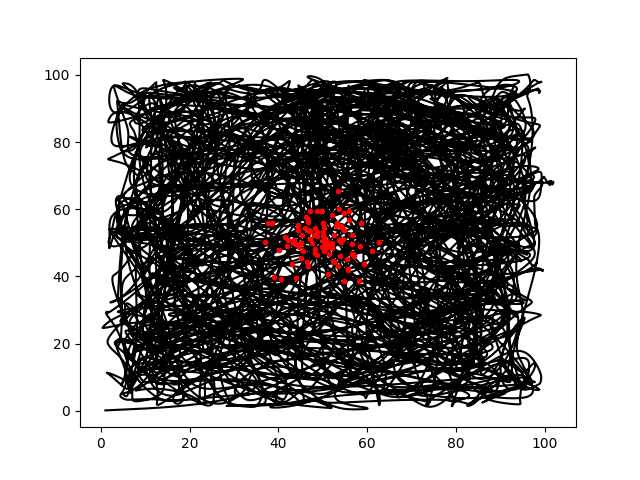

In [4]:

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k')
plt.plot(x_coordinates[I_timestamps],y_coordinates[I_timestamps],'r.')
plt.show()



In [5]:

x_grid,y_grid,x_center_bins,y_center_bins = get_position_grid(x_coordinates,y_coordinates,nbins_pos_x,nbins_pos_y)
position_occupancy = get_occupancy(x_coordinates,y_coordinates,x_grid,y_grid,video_srate)


plt.figure()
plt.pcolormesh(x_center_bins,y_center_bins,position_occupancy)
plt.colorbar()
plt.show()


NameError: name 'get_position_grid' is not defined

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
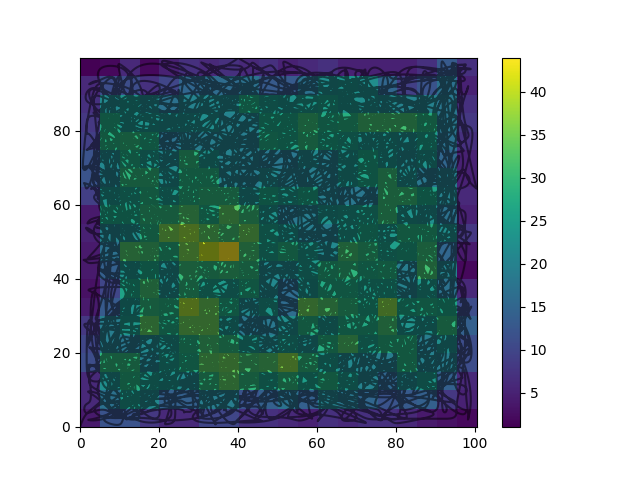

In [10]:
visits_occupancy = get_visits(x_coordinates,y_coordinates,x_grid,y_grid,x_center_bins,y_center_bins)

plt.figure()
plt.pcolormesh(x_center_bins,y_center_bins,visits_occupancy)
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.5)
plt.colorbar()
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
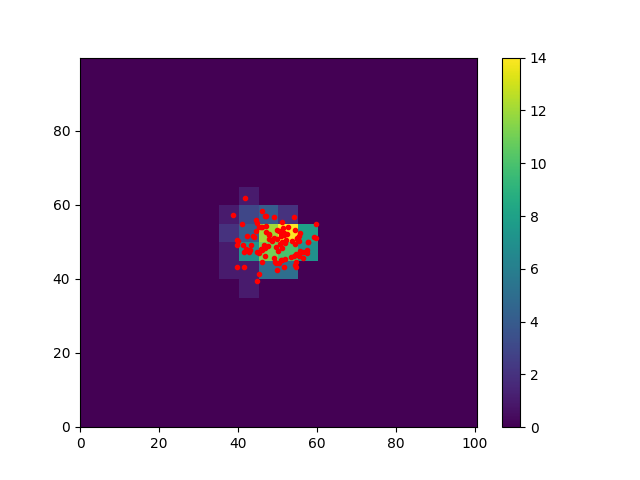

In [11]:

spike_rate_occupancy = get_spike_occupancy(I_timestamps,x_coordinates,y_coordinates,x_grid,y_grid)

plt.figure()
plt.pcolormesh(x_center_bins,y_center_bins,spike_rate_occupancy)
# plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.plot(x_coordinates[I_timestamps],y_coordinates[I_timestamps],'r.',alpha=1)

plt.colorbar()
plt.show()


In [402]:

I_sec,I_spk = spatial_metrics(spike_rate_occupancy,position_occupancy)
I_spk


4.405997808426769

In [13]:
srate = 1000
spike_timevector = get_spiketimes_binarized(I_timestamps,timevector,srate)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
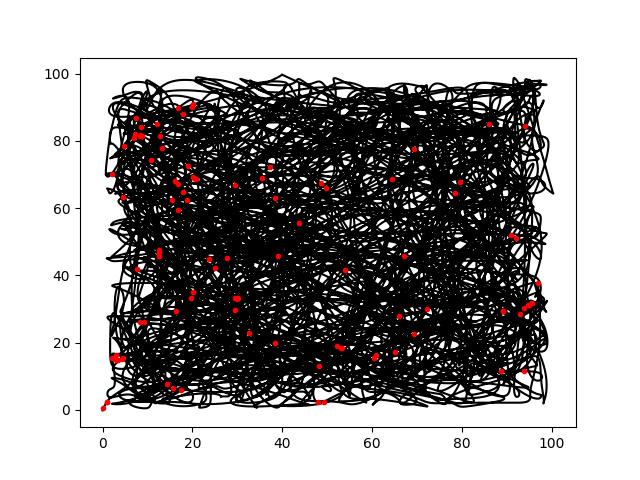

2.6310494368948785

In [14]:
spike_timevector_shuffled = get_surrogate(spike_timevector,srate,10)
I_timestamps_shuffled = np.where(spike_timevector_shuffled)[0]

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k')
plt.plot(x_coordinates[I_timestamps_shuffled],y_coordinates[I_timestamps_shuffled],'r.')
plt.show()

spike_rate_occupancy_shuffled = get_spike_occupancy(I_timestamps_shuffled,x_coordinates,y_coordinates,x_grid,y_grid)
I_sec_shuffled,I_spk_shuffled = spatial_metrics(spike_rate_occupancy_shuffled,position_occupancy)

I_spk_shuffled


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
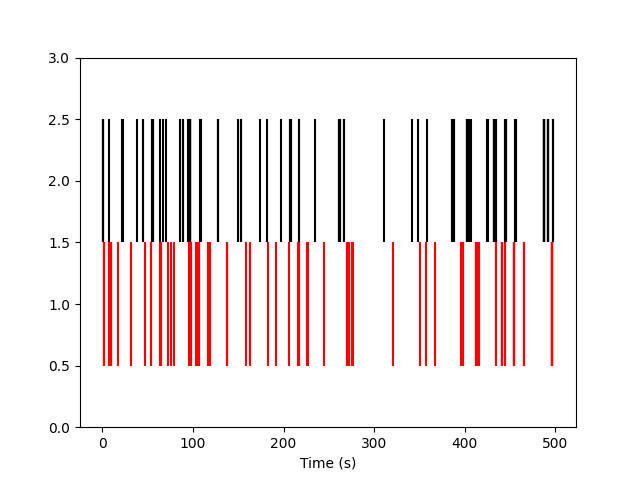

In [17]:

plt.figure()
plt.eventplot(timevector[I_timestamps_shuffled],color='k',lineoffset=2)
plt.eventplot(timevector[I_timestamps],color='r')
plt.xlabel('Time (s)')
plt.ylim([0,3])
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
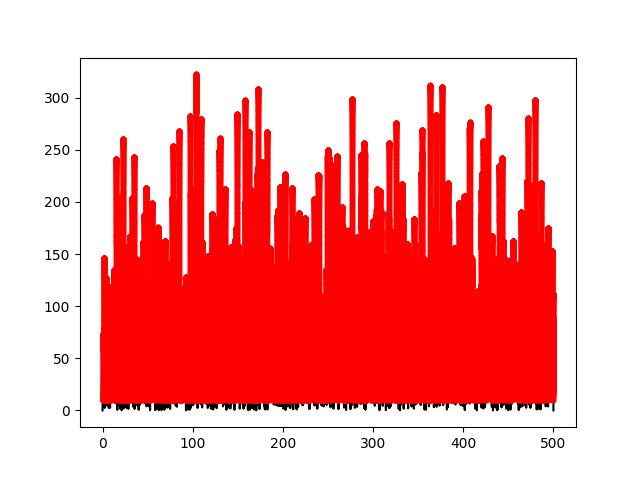

In [406]:
speed_threshold = 10
I_speed_thres = get_valid_timepoints(x_coordinates,y_coordinates,timevector,speed_threshold)

plt.figure()
plt.plot(timevector,speed,'k')
plt.plot(timevector[I_speed_thres],speed[I_speed_thres],'r.')
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
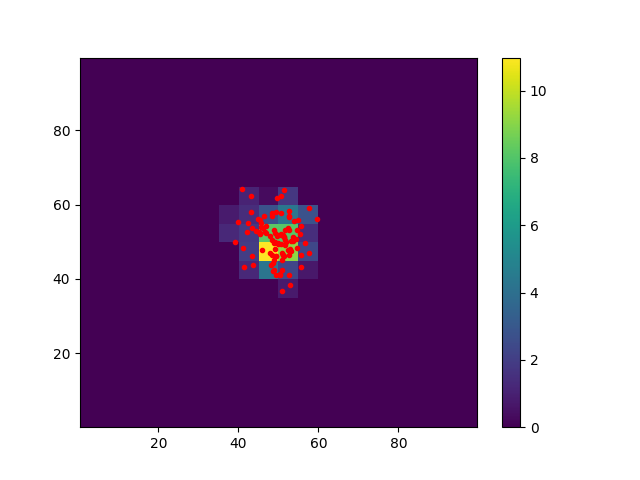

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
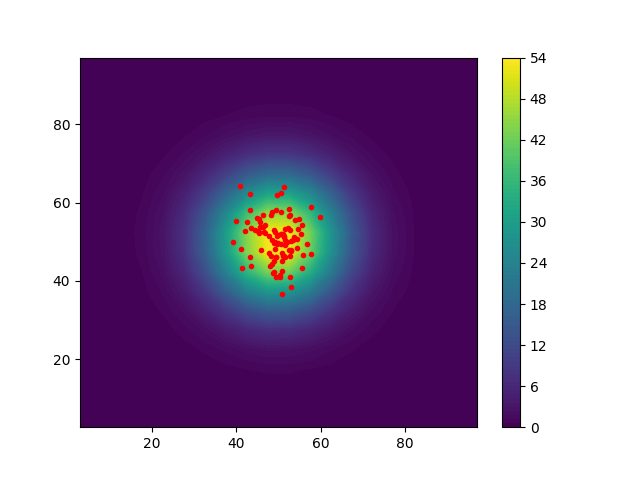

4.460232541429844

In [425]:
mintimespent = 0
minvisits = 0

place_field,place_field_smoothed = placeField(spike_rate_occupancy,position_occupancy,visits_occupancy,mintimespent, minvisits)


plt.close('all')

plt.figure()
plt.pcolormesh(x_center_bins,y_center_bins,place_field)
# plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.plot(x_coordinates[I_timestamps],y_coordinates[I_timestamps],'r.',alpha=1)
plt.colorbar()
plt.show()

plt.figure()
plt.contourf(x_center_bins,y_center_bins,place_field_smoothed,100)
# plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.plot(x_coordinates[I_timestamps],y_coordinates[I_timestamps],'r.',alpha=1)
plt.colorbar()
plt.show()


I_sec,I_spk = spatial_metrics(place_field,position_occupancy)
I_spk

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
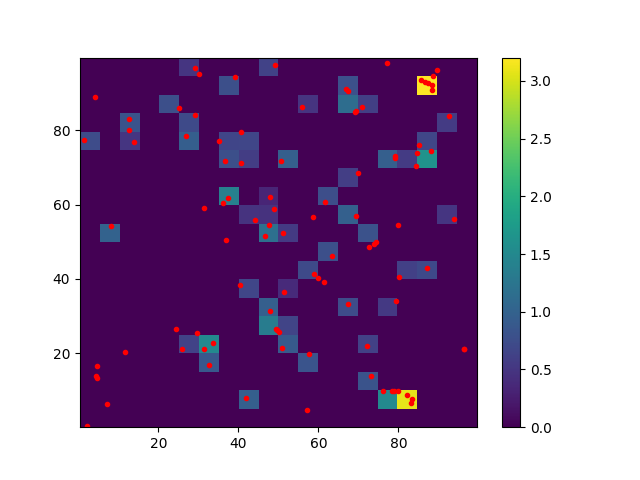

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
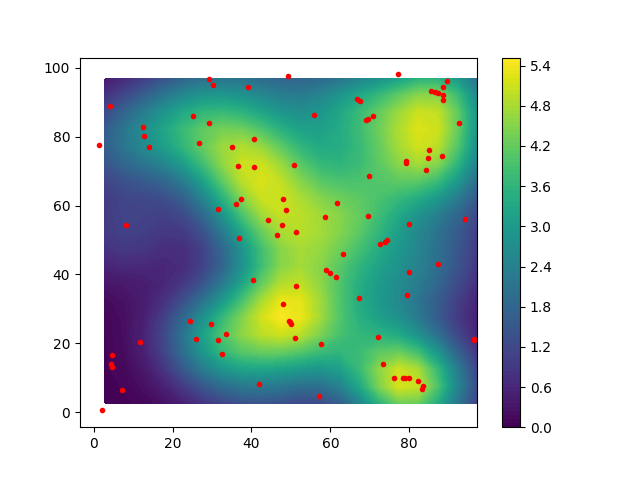

2.657293310478899

In [431]:

mintimespent = 1
minvisits = 1


spike_timevector_shuffled = get_surrogate(spike_timevector,srate,10)
I_timestamps_shuffled = np.where(spike_timevector_shuffled)[0]

spike_rate_occupancy_shuffled = get_spike_occupancy(I_timestamps_shuffled,x_coordinates,y_coordinates,x_grid,y_grid)
place_field_shuffled,place_field_smoothed_shuffled = placeField(spike_rate_occupancy_shuffled,position_occupancy,visits_occupancy,mintimespent, minvisits)

I_sec_shuffled,I_spk_shuffled = spatial_metrics(place_field_shuffled,position_occupancy)



plt.close('all')

plt.figure()
plt.pcolormesh(x_center_bins,y_center_bins,place_field_shuffled)
# plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.plot(x_coordinates[I_timestamps_shuffled],y_coordinates[I_timestamps_shuffled],'r.',alpha=1)
plt.colorbar()
plt.show()

plt.figure()
plt.contourf(x_center_bins,y_center_bins,place_field_smoothed_shuffled,100)
# plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.plot(x_coordinates[I_timestamps_shuffled],y_coordinates[I_timestamps_shuffled],'r.',alpha=1)
plt.colorbar()
plt.show()
I_spk_shuffled



In [437]:

mintimespent = 1
minvisits = 1

I_sec_shuffled = []
I_spk_shuffled = []
for shuff in range(100):
    spike_timevector_shuffled = get_surrogate(spike_timevector,srate,10)
    I_timestamps_shuffled = np.where(spike_timevector_shuffled)[0]

    spike_rate_occupancy_shuffled = get_spike_occupancy(I_timestamps_shuffled,x_coordinates,y_coordinates,x_grid,y_grid)
    place_field_shuffled,place_field_smoothed_shuffled = placeField(spike_rate_occupancy_shuffled,position_occupancy,visits_occupancy,mintimespent, minvisits)

    I_sec_shuffled_aux,I_spk_shuffled_aux = spatial_metrics(place_field_shuffled,position_occupancy)

    I_sec_shuffled.append(I_sec_shuffled_aux)
    I_spk_shuffled.append(I_spk_shuffled_aux)
    
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
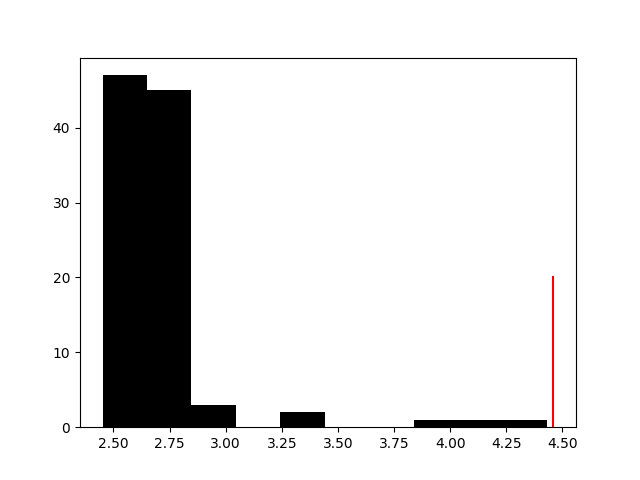

In [438]:

plt.figure()
plt.hist(I_spk_shuffled,color='black')
plt.plot([I_spk,I_spk],[0,20],'r')
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
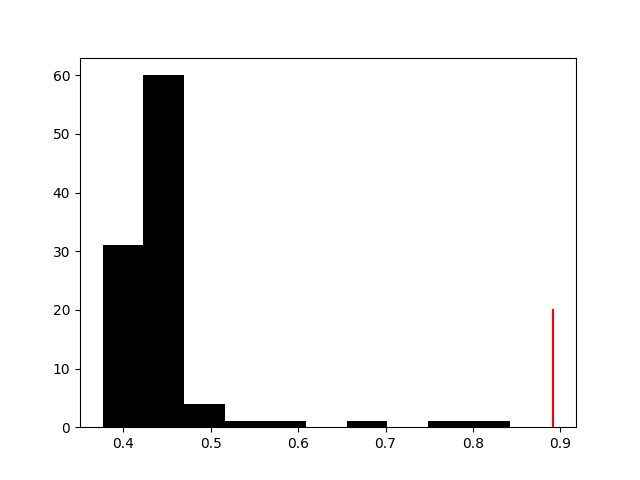

In [439]:

plt.figure()
plt.hist(I_sec_shuffled,color='black')
plt.plot([I_sec,I_sec],[0,20],'r')
plt.show()


In [8]:
def get_speed(x_coordinates,y_coordinates,timevector):

    speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)
    speed = hf.smooth(speed/np.diff(timevector),window_len=10)
    speed = np.hstack([speed,0])
    return speed

def get_valid_timepoints(x_coordinates,y_coordinates,timevector,speed_threshold):

    speed = get_speed(x_coordinates,y_coordinates,timevector)
    I_speed_thres = speed > speed_threshold
 
    return I_speed_thres


def placeField(spike_rate_occupancy,position_occupancy,visits_occupancy,mintimespent, minvisits):

    place_field = spike_rate_occupancy/position_occupancy

    Valid=(position_occupancy>=mintimespent)*(visits_occupancy>=minvisits)*1.
    Valid[Valid == 0] = np.nan
    place_field = place_field*Valid

    place_field_to_smooth = np.copy(place_field)
    place_field_to_smooth[np.isnan(place_field_to_smooth)] = 0
    place_field_smoothed = gaussian_smooth_2d(place_field_to_smooth,2)

    return place_field,place_field_smoothed


def get_binned_2Dposition(x_coordinates,y_coordinates,x_grid,y_grid):

    # calculate position occupancy
    position_binned = np.zeros(x_coordinates.shape) 
    count = 0
    for xx in range(0,x_grid.shape[0]-1):
        for yy in range(0,y_grid.shape[0]-1):

            check_x_ocuppancy = np.logical_and(x_coordinates >= x_grid[xx],x_coordinates < (x_grid[xx+1]))
            check_y_ocuppancy = np.logical_and(y_coordinates >= y_grid[yy],y_coordinates < (y_grid[yy+1]))
            position_binned[np.logical_and(check_x_ocuppancy,check_y_ocuppancy)] = count
            count += 1

    return position_binned


def gaussian_smooth_2d(input_matrix,s_in):
    import numpy as np
    from scipy import signal as sig

    gaussian2d = gaussian2d_kernel(s_in)
    smoothed_matrix = sig.convolve2d(input_matrix,gaussian2d,mode='same')
    
    return smoothed_matrix

def gaussian2d_kernel(s):
    import numpy as np
    x_vec = np.arange(-100,101,1)
    y_vec = np.arange(-100,101,1)
#     s = 2
    gaussian_kernel = np.zeros([y_vec.shape[0],x_vec.shape[0]])
    x_count = 0
    for xx in x_vec:
        y_count = 0
        for yy in y_vec:
            gaussian_kernel[y_count,x_count] = np.exp(-((xx**2 + yy**2)/(2*(s**2))))

            y_count += 1
        x_count += 1

    return gaussian_kernel



def get_spiketimes_binarized(I_timestamps,timevector,srate):
    spike_timevector = np.zeros(int(srate*timevector[-1]))
    spike_timevector[I_timestamps] = 1
    
    return spike_timevector


def get_surrogate(input_vector,srate,shuffling_max_time):
    eps = np.finfo(float).eps
    I_break = np.random.choice(np.arange(-shuffling_max_time*srate,srate*shuffling_max_time),1)[0].astype(int)
    input_vector_shuffled = np.concatenate([input_vector[I_break:], input_vector[0:I_break]])

    return input_vector_shuffled



def spatial_metrics(place_field,position_occupancy):

    place_field[np.isinf(place_field) | np.isnan(place_field)] = 0
    non_zero_vals = place_field != 0
    
    noccup_ratio = position_occupancy/np.nansum(position_occupancy)
    overall_frate = np.nansum(place_field[non_zero_vals]*noccup_ratio[non_zero_vals])

    
    # bits per second
    I_sec = np.nansum(place_field[non_zero_vals]*noccup_ratio[non_zero_vals]*np.log2(place_field[non_zero_vals]/overall_frate))
    # bits per spike
    I_spk = I_sec/overall_frate
    # I_spk = np.nansum((spike_rate_occupancy[non_zero_vals]/overall_frate)*noccup_ratio[non_zero_vals]*np.log2(spike_rate_occupancy[non_zero_vals]/overall_frate))



    return I_sec,I_spk



def get_spike_occupancy(I_timestamps,x_coordinates,y_coordinates,x_grid,y_grid):

    # calculate mean calcium per pixel
    spike_rate_occupancy = np.nan*np.zeros((y_grid.shape[0]-1,x_grid.shape[0]-1)) 
    for xx in range(0,x_grid.shape[0]-1):
        for yy in range(0,y_grid.shape[0]-1):

            check_x_ocuppancy = np.logical_and(x_coordinates >= x_grid[xx],x_coordinates < (x_grid[xx+1]))
            check_y_ocuppancy = np.logical_and(y_coordinates >= y_grid[yy],y_coordinates < (y_grid[yy+1]))
            I_location = np.where(np.logical_and(check_x_ocuppancy,check_y_ocuppancy))[0]
            # spike_rate_occupancy[yy,xx] = np.sum(np.in1d(I_timestamps,I_location))/I_location.shape[0]
            spike_rate_occupancy[yy,xx] = np.sum(np.in1d(I_timestamps,I_location))
    return spike_rate_occupancy



def get_position_grid(x_coordinates,y_coordinates,nbins_pos_x,nbins_pos_y):
    # here someone should also be able to set the enviroment edges

    x_range = (np.nanmax(x_coordinates) - np.nanmin(x_coordinates))
    x_grid_window = x_range/nbins_pos_x
    x_grid = np.arange(np.nanmin(x_coordinates),np.nanmax(x_coordinates) +x_grid_window/2,x_grid_window)

    y_range = (np.nanmax(y_coordinates) - np.nanmin(y_coordinates))
    y_grid_window = y_range/nbins_pos_y
    y_grid = np.arange(np.nanmin(y_coordinates),np.nanmax(y_coordinates)+y_grid_window/2,y_grid_window)

    x_center_bins = x_grid[0:-1] + x_grid_window/2
    y_center_bins = y_grid[0:-1] + y_grid_window/2

    return x_grid,y_grid,x_center_bins,y_center_bins


def get_occupancy(x_coordinates,y_coordinates,x_grid,y_grid,video_srate):
    # calculate position occupancy
    position_occupancy = np.zeros((y_grid.shape[0]-1,x_grid.shape[0]-1))
    for xx in range(0,x_grid.shape[0]-1):
        for yy in range(0,y_grid.shape[0]-1):

            check_x_ocuppancy = np.logical_and(x_coordinates >= x_grid[xx],x_coordinates < (x_grid[xx+1]))
            check_y_ocuppancy = np.logical_and(y_coordinates >= y_grid[yy],y_coordinates < (y_grid[yy+1]))

            position_occupancy[yy,xx] = np.sum(np.logical_and(check_x_ocuppancy,check_y_ocuppancy))/video_srate

    return position_occupancy





def get_visits(x_coordinates,y_coordinates,x_grid,y_grid,x_center_bins,y_center_bins):

    I_x_coord = []
    I_y_coord = []

    for xx in range(0,x_coordinates.shape[0]):
        I_x_coord.append(np.argmin(np.abs(x_coordinates[xx] - x_center_bins)))
        I_y_coord.append(np.argmin(np.abs(y_coordinates[xx] - y_center_bins)))

    I_x_coord = np.array(I_x_coord)
    I_y_coord = np.array(I_y_coord)

    dx = np.diff(np.hstack([I_x_coord[0]-1,I_x_coord]))
    dy = np.diff(np.hstack([I_y_coord[0]-1,I_y_coord]))

    newvisitstimes = (-1*(dy == 0))*(dx==0)+1
    newvisitstimes2 = (np.logical_or((dy != 0), (dx!=0))*1)

    I_visit = np.where(newvisitstimes>0)[0]

    # calculate visits


    x_coordinate_visit = x_coordinates[I_visit]
    y_coordinate_visit = y_coordinates[I_visit]

    visits_occupancy = np.zeros((y_grid.shape[0]-1,x_grid.shape[0]-1))        
    for xx in range(0,x_grid.shape[0]-1):
        for yy in range(0,y_grid.shape[0]-1):

            check_x_ocuppancy = np.logical_and(x_coordinate_visit >= x_grid[xx],x_coordinate_visit < (x_grid[xx+1]))
            check_y_ocuppancy = np.logical_and(y_coordinate_visit >= y_grid[yy],y_coordinate_visit < (y_grid[yy+1]))

            visits_occupancy[yy,xx] = np.sum(np.logical_and(check_x_ocuppancy,check_y_ocuppancy))

    return visits_occupancy



In [ ]:

PlaceCellObject = place_cell.main(calcium_imag,timevector,x_coordinates,y_coordinates)


/home/apolo/Documents/DataAnalysis/Projects/CalciumSignalAnalysis/spatial_metrics_base.py:205: RuntimeWarning: Mean of empty slice
  calcium_mean_occupancy[yy,xx] = np.nanmean(mean_calcium_to_behavior_speed[np.logical_and(check_x_ocuppancy,check_y_ocuppancy)])


In [8]:

plt.figure()
plt.hist(PlaceCellObject['gridness_permutation'],20)
plt.plot([PlaceCellObject['gridness_original'],PlaceCellObject['gridness_original']],[0,25],'r--',linewidth=2)
plt.title(PlaceCellObject['gridness_zscored'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'PlaceCellObject' is not defined